In [1]:
import sys
import pathlib
import os
from skmap.catalog import DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data, calc_metrics

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'
version = '20250404'

In [2]:
# read in
train = pd.read_parquet(f'{folder_path}/data/006_data_train_v{version}.pq')
test = pd.read_parquet(f'{folder_path}/data/004_data_test_v{version}.pq')
test = test
prop = 'ocd'
tgt = 'ocd_log1p'
train[tgt] = np.log1p(train[prop])
test[tgt] = np.log1p(test[prop])

# with open(f'{folder_path}/data/007_cov_all.json', "r") as file:
#     covs = json.load(file)
    
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')

In [3]:
train.loc[(train['ocd']==0) & (train['lc_survey']!= 'bare land & lichens/moss')]

,time,lat,lon,hzn_dep,id,ref,nuts0,lc_survey,ocd,evi_glad.landsat.ard2.seasconv_m_30m_s_YYYY0101_YYYY0228_eu_epsg.3035_v20231127,...,neg.openess.bareearth_ensemble_m_240m_s_20000101_20221231_eu_epsg.3035_v20240501,ai_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531,lithology.81.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif,hillshade.bareearth_ensemble_m_30m_s_20000101_20221231_eu_epsg.3035_v20240424,slope.bareearth_ensemble_m_480m_s_20000101_20221231_eu_epsg.3035_v20240501,pet.penman.min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531,bioclim.var_chelsa.bio18_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822,tile_id,hzn_dep_bin,ocd_log1p
754,2008,39.026389,-8.129722,57.5,3386-9700,infosolo,PT,woodland,0.0,162.0,...,156.0,0.499915,0.0,253.0,104.0,3400.0,280.0,563,50-100,0.0
1332,2008,39.169167,-8.167500,70.0,3382-9681,infosolo,PT,woodland,0.0,153.0,...,155.0,0.548303,0.0,252.0,137.0,3493.0,314.0,563,50-100,0.0
30346,2008,38.795000,-8.633889,67.5,3390-9712,infosolo,PT,woodland,0.0,155.0,...,155.0,0.523883,0.0,250.0,178.0,3503.0,383.0,526,50-100,0.0
36181,2008,39.026389,-8.129722,37.5,3386-9699,infosolo,PT,woodland,0.0,162.0,...,156.0,0.499915,0.0,253.0,104.0,3400.0,280.0,563,20-50,0.0


# With pseudo-zero

In [4]:
model = RandomForestRegressor(random_state=42, n_jobs=80, n_estimators=100)
model.fit(train[covs], train[tgt])
       
y_pred = model.predict(test[covs])

mae 0.415380660997527 ; medae 0.29835444659530364 ; bias -0.0050190216868920695
ccc 0.7636146219203416 :, r2 0.6219552607012475


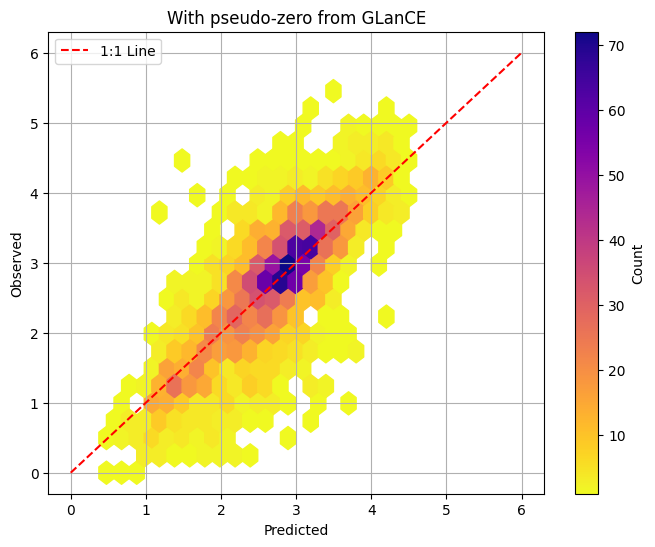

In [6]:
mtc = calc_metrics(test[tgt], y_pred, weights=None, space='log1p')
print('mae', mtc[0], '; medae', mtc[1], '; bias', mtc[5])
print('ccc', mtc[3], ':, r2', mtc[4])

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
hb = plt.hexbin(y_pred, test[tgt], gridsize=20, cmap='plasma_r', mincnt=1)
cb = plt.colorbar(hb)
cb.set_label('Count')

# Plot the 1:1 line
plt.plot([0, 6], [0, 6], color='red', linestyle='--', label='1:1 Line')

# Add labels and legend
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('With pseudo-zero from GLanCE')
plt.legend()
plt.grid(True)
plt.show()

# No pseudo-zero

In [7]:
train = train.loc[train['ref']!='GLanCE']
test = test.loc[test['ref']!='GLanCE']

model = RandomForestRegressor(random_state=42, n_jobs=80, n_estimators=100)
model.fit(train[covs], train[tgt])
       
y_pred = model.predict(test[covs])

mae 0.41264854913546123 ; medae 0.30078444825435036 ; bias -0.0013082479375194937
ccc 0.7699909120810475 :, r2 0.6309686727023974


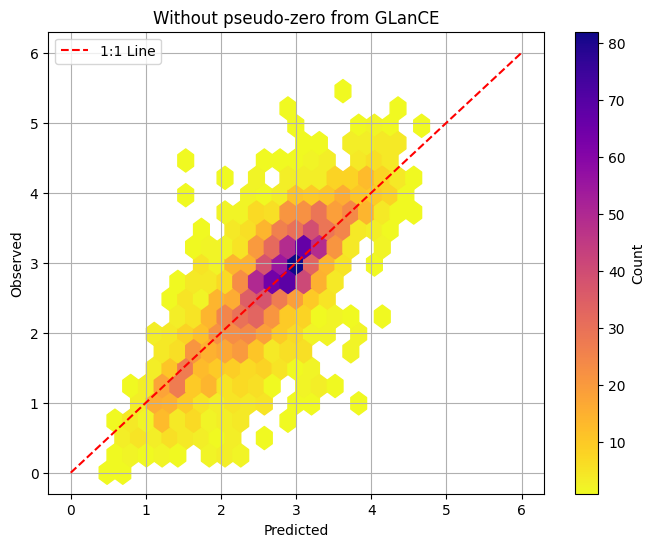

In [9]:
mtc = calc_metrics(test[tgt], y_pred, weights=None, space='log1p')
print('mae', mtc[0], '; medae', mtc[1], '; bias', mtc[5])
print('ccc', mtc[3], ':, r2', mtc[4])

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
hb = plt.hexbin(y_pred, test[tgt], gridsize=20, cmap='plasma_r', mincnt=1)
cb = plt.colorbar(hb)
cb.set_label('Count')

# Plot the 1:1 line
plt.plot([0, 6], [0, 6], color='red', linestyle='--', label='1:1 Line')

# Add labels and legend
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Without pseudo-zero from GLanCE')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion: inclusion of pseudo zero points doesn't affect model predictions